In [30]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
all_photos = np.load('KnightPhotos.npy')

all_labels = np.load('KnightLabels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load('KnightVectors.npy')

all_degrees = np.load('KnightRotationDegrees.npy')
all_albedos = np.load('KnightAlbedos.npy')
all_normals = np.load('KnightNormals.npy')
all_masks = np.load('KnightMasks.npy')

In [32]:
def masstest(mylist):
    numlist = mylist 
    intotheflames = list()
    testanswers = list()
    
    intotheflames.append(all_photos[numlist])
    testanswers.append(answerList[numlist])
    
    intotheflames = np.array(intotheflames)[0]
    testanswers = np.array(testanswers)[0]
    print(intotheflames.shape)
    imgimg = generator.predict(intotheflames)
    disc_opinion_fake = discriminator.predict(imgimg).round(3)
    disc_opinion_real = discriminator.predict(testanswers).round(3)
    #print("Fake:      Real:\n",np.concatenate([disc_opinion_fake, disc_opinion_real], axis=1) , sep='')
    print("Fake:", disc_opinion_fake.reshape(-1),  "\nReal:", disc_opinion_real.reshape(-1), sep='')
    #finalimage = np.concatenate([np.take(imgimg, [0,1,2,3], axis=0), np.take(testanswers, [0,1,2,3], axis=0)], axis=1)
    r1 =  np.concatenate(np.take(imgimg, [0,1,2,3], axis=0), axis=1)
    r2 =  np.concatenate(np.take(testanswers, [0,1,2,3], axis=0), axis=1)
    r3 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=1)
    r4 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=1)
    finalimage = np.concatenate([r1,r2,r3,r4], axis=0)
    return finalimage

71 8


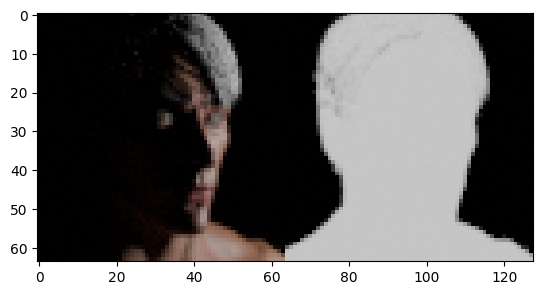

In [33]:
batch_size = 64
train_size = int(0.95 * len(all_labels)) # SMALL DATASET FOR TESTING

dictDegrees = dict()
for i in range(len(all_degrees)):
    dictDegrees[all_degrees[i]] = all_masks[i]

answerList = list()
for i in range(len(all_photos)):
    answerList.append(dictDegrees[all_labels[i]])
answerList = np.array(answerList)

dataset = tf.data.Dataset.from_tensor_slices((all_photos, answerList))
#dataset = dataset.shuffle(buffer_size=512, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(32)

print(len(list(train_dataset)), len(list(test_dataset)))
imtoshownum = 3000
imtoshow = np.concatenate( [all_photos[imtoshownum], answerList[imtoshownum]], axis=1).astype("float32")
plt.imshow(imtoshow)

In [34]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((64, 64, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1, activation="relu"),
    ],
    name="discriminator",
)
discriminator.compile(#optimizer='adam',
              loss='mean_absolute_error', #mean_squared_error
              metrics=['mean_absolute_error']
)
#discriminator.summary()

In [35]:
# Create the generator.
dropdrop = 0.3
generator = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(4, (5,5), input_shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(5, (5,5)), tf.keras.layers.Conv2D(5, (5,5)),
        tf.keras.layers.Conv2D(6, (5,5)), tf.keras.layers.Conv2D(6, (5,5)),
        tf.keras.layers.Conv2D(7, (5,5)), tf.keras.layers.Conv2D(7, (5,5)),
        tf.keras.layers.Conv2D(8, (5,5)), tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(4*8*8, activation="relu"),
        #tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(dropdrop),
        tf.keras.layers.Dense(4*8*8, activation="relu"),
        #tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(dropdrop),
        tf.keras.layers.Dense(8*8*8, activation="relu"),
        #tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(dropdrop),
        tf.keras.layers.Dense(16 * 16 * 6, activation="relu"),
        #tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(dropdrop),
        
        tf.keras.layers.Reshape((16, 16, 6,)),
        tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="LeakyReLU"),
        #tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        tf.keras.layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.compile(#optimizer='adam',
              loss='mean_absolute_error', #mean_squared_error
              #metrics=['mean_absolute_error']
)        
#generator.summary()

In [36]:
#generator.summary()

In [37]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
d_optimizer=keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer_label=keras.optimizers.Adam(learning_rate=0.000002)
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00001)
gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

In [40]:
num_epochs = 10
for epoch in range(num_epochs):
    print("start training epoch ", epoch)
    for batch_idx, (photos, normals) in enumerate(train_dataset):

        #print(photos.shape, normals.shape)
        generated_normals = generator(photos)
        #print(generated_normals)
        combined_images = np.concatenate( [generated_normals, normals], axis=0 )
        # Assemble labels discriminating real from fake images.
        labels = np.concatenate( [np.ones((generated_normals.shape[0], 1)), np.zeros((normals.shape[0], 1))], axis=0)
        
        # Train the DISCRIMINATOR.
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images)
            d_loss = loss_fn(labels, predictions)
        #print(d_loss)
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients( zip(grads, discriminator.trainable_weights) )
        
        # Train the using labels.
        with tf.GradientTape() as tape:
            fake_images = generator(photos)
            misleading_labels = np.zeros((fake_images.shape[0], 1))
            
            predictions = discriminator(fake_images)
            g_loss = loss_fn(misleading_labels, predictions)
        #print(g_loss, mae)
        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer_label.apply_gradients(zip(grads, generator.trainable_weights))
        # Train the using difference of real and fake.
        with tf.GradientTape() as tape:
            fake_images = generator(photos)
            mae = tf.reduce_mean(tf.abs(fake_images - normals))
        grads2 = tape.gradient(mae, generator.trainable_weights)
        g_optimizer_image.apply_gradients(zip(grads2, generator.trainable_weights))
        
        # gen_loss_tracker.update_state(g_loss)
        # disc_loss_tracker.update_state(d_loss)
        print("g_loss:", g_loss, "d_loss:", d_loss) 

start training epoch  0
g_loss: tf.Tensor(1.0963306, shape=(), dtype=float32) d_loss: tf.Tensor(0.5524621, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1083118, shape=(), dtype=float32) d_loss: tf.Tensor(0.54999715, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1142396, shape=(), dtype=float32) d_loss: tf.Tensor(0.55049646, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1275955, shape=(), dtype=float32) d_loss: tf.Tensor(0.54472595, shape=(), dtype=float32)
g_loss: tf.Tensor(1.139187, shape=(), dtype=float32) d_loss: tf.Tensor(0.5424307, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1509726, shape=(), dtype=float32) d_loss: tf.Tensor(0.5401782, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1644952, shape=(), dtype=float32) d_loss: tf.Tensor(0.5454484, shape=(), dtype=float32)
g_loss: tf.Tensor(1.167855, shape=(), dtype=float32) d_loss: tf.Tensor(0.5447204, shape=(), dtype=float32)
g_loss: tf.Tensor(1.1649525, shape=(), dtype=float32) d_loss: tf.Tensor(0.54186946, shape=(), dtype=float32)
g_

(8, 64, 64, 3)
1/1 [==============================] - 0s 19ms/step
Fake:[5.595 6.05  5.979 4.791 5.918 5.806 5.746 5.906]
Real:[0.122 0.153 0.    0.    0.122 0.    0.    0.   ]
(256, 256, 3)


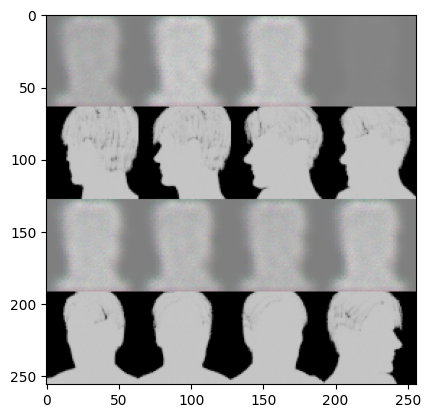

In [41]:
toinset = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
bigpicture = masstest(toinset)
print(bigpicture.shape)
plt.imshow(bigpicture.astype("float32"))

1/1 [==============================] - 0s 434ms/step


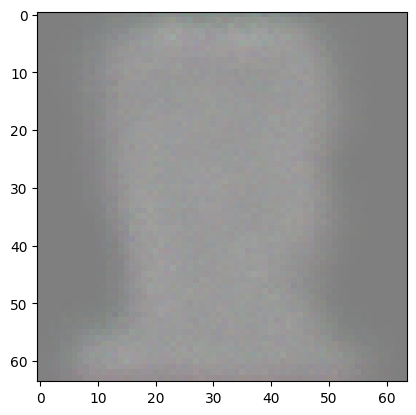

In [42]:
singletest = generator.predict(all_photos[1520].reshape(1,64,64,3))
plt.imshow(singletest[0])